In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
Data = pd.read_excel('SWC.xlsx')    
for i in Data.index:
    Data.loc[i,'DateTime'] = datetime.datetime.strptime(str(Data.loc[i,'year'])+ ' ' +
                                                        str(Data.loc[i,'day'])+ ' ' +
                                                        str(Data.loc[i,'hhmm']).zfill(4),'%Y %j %H%M')
Data.set_index('DateTime',inplace=True)
Data.drop(['year','day','hhmm'],axis=1,inplace=True)

In [4]:
Data.where(Data>0.03,np.nan,inplace=True)
Data.where(Data<0.8,np.nan,inplace=True)

## Have a look at the data

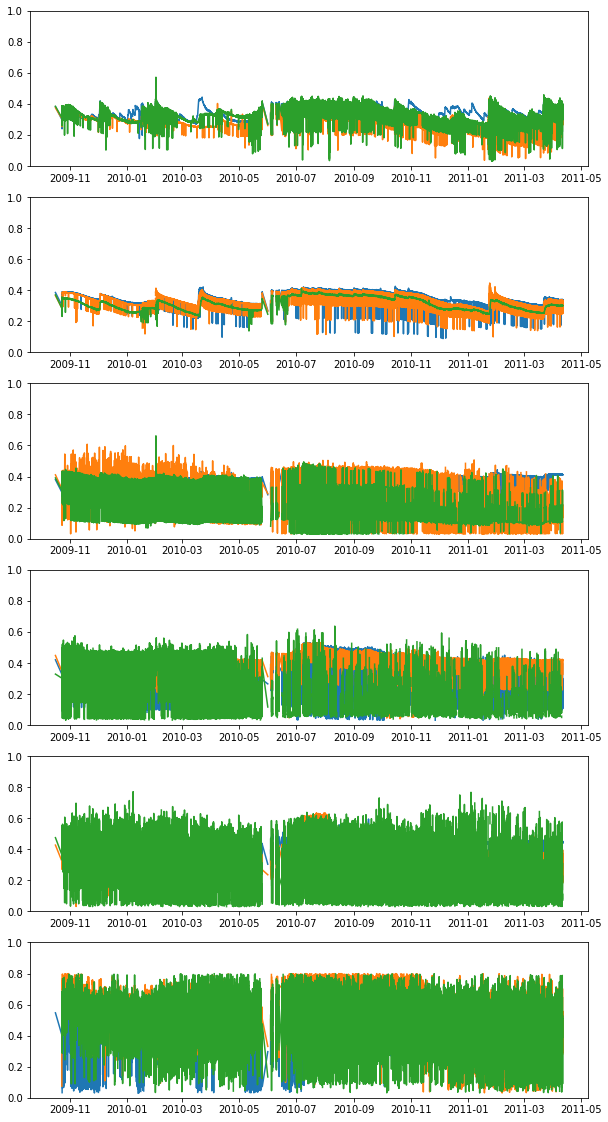

In [5]:
Fig = plt.figure(figsize=(10,20))
pos=1
for s in [1,2,3,4,5,6]:
    Ax = Fig.add_subplot(6,1,pos)
    R1 = 'swc-' + str(s)
    R2 = 'swc-' + str(s+6)
    R3 = 'swc-' + str(s+12)
    plt.plot(Data.loc[:,(R1,R2,R3)],'-')
    plt.ylim(0,1)
    pos+=1

## 30 min data is noisey as crap.  Appears to be throwing low readings.  Lets try looking at the daily maximum

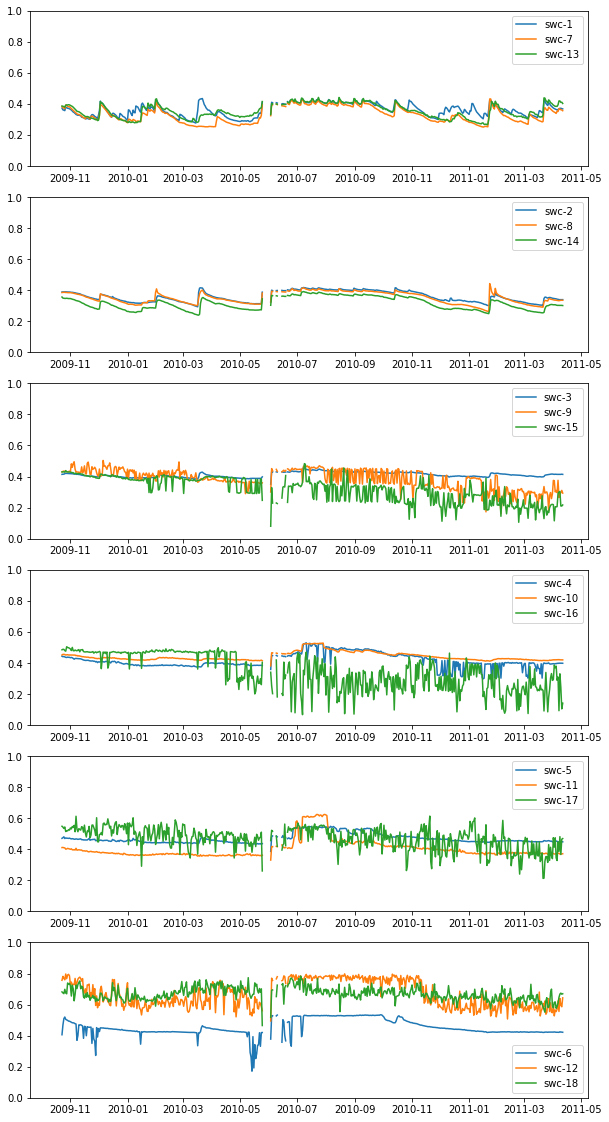

In [6]:
Fig = plt.figure(figsize=(10,20))
pos=1
for s in [1,2,3,4,5,6]:
    Ax = Fig.add_subplot(6,1,pos)
    R1 = 'swc-' + str(s)
    R2 = 'swc-' + str(s+6)
    R3 = 'swc-' + str(s+12)
    for rep in [R1,R2,R3]:
        plt.plot(Data.loc[:,rep].resample('d').apply(lambda x: x.quantile(0.9)),'-',label=rep)
        plt.ylim(0,1)
    plt.legend()
    pos+=1

## Even looking at the 95th percentile value for the day (assuming most of the errant values were on the low side but a few were on the high side) there are a number of sensors giving crap data.  Will need to exclude these

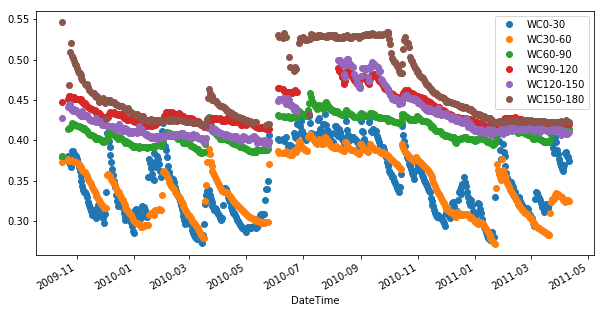

In [18]:
DailyData = pd.DataFrame(index = Data.resample('D').mean().index,
                        columns = ['WC0-30','WC30-60','WC60-90',
                                   'WC90-120','WC120-150','WC150-180'])
def SetData(layer, s, use):
    R1 = 'swc-' + str(s)
    R2 = 'swc-' + str(s+6)
    R3 = 'swc-' + str(s+12)
    Daily = Data.loc[:,(R1,R2,R3)].resample('d').apply(lambda x: x.quantile(0.9))
    DailyData.loc[:,layer] = Daily.iloc[:,use].mean(axis=1) 

SetData('WC0-30', 1, [0,1,2])
SetData('WC30-60', 2, [0,1,2])
SetData('WC60-90', 3, [0])
SetData('WC90-120', 4, [1])
SetData('WC120-150', 5, [0,1])
SetData('WC150-180', 6, [0])
DailyData.dropna(how='all',inplace=True)
DailyData.loc[:,'WC150-180'] = DailyData.loc[:,'WC150-180'].where(DailyData.loc[:,'WC150-180']>0.41,np.nan)
DailyData.loc['2010-05-26':'2010-06-3',:] = np.nan
DailyData.loc['2010-06-25':'2010-08-06',('WC90-120','WC120-150')] = np.nan
DailyData.dropna(how='all',inplace=True)

DailyData.plot(figsize=(10,5),style='o')

In [19]:
DailyData.to_pickle('SWC.pkl')